## Figure 3

This manuscript generates figure 3 and relavent data of the paper. 

Kexin Dong

May 27, 2024  

In [373]:
import bioh2m as h2m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import time
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import seaborn as sns
import statannot
import matplotlib.colors as mcolors
import scipy.stats
from matplotlib.ticker import FuncFormatter
from sksurv.nonparametric import kaplan_meier_estimator # pip install scikit-survival
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

## Figure 3c  
Recurrent frequencies of KIT missense mutations in cancer patients according to AACR-GENIE. Mutations are colored by H2M modeling. No flank size limit. Red dashed line = occurred in 5 patients. 

In [252]:
df_input = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/aacr_input_original.csv')
df_input_sub = df_input[(df_input['gene_name_h']=='KIT')]

In [236]:
df_binded = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/database-output-final/df_result_cleaned_v3.csv')

In [250]:
df_kit_all = df_binded[(df_binded['gene_name_h']=='KIT') & (df_binded['classification_h']=='Missense')]

In [253]:
df_kit_all = df_kit_all.reset_index(drop=True)
df_kit_aacr = df_kit_all[df_kit_all['Database']=='AACR']
df_kit_aacr = df_kit_aacr[df_kit_aacr['ID_human'].isin(df_input_sub['ID'])]
df_kit_aacr = df_kit_aacr.reset_index(drop=True)
# del bf_binded

In [350]:
df_input_sub = df_input_sub.rename(columns = {'ID':'ID_human'})
df_freq = pd.merge(df_input_sub, df_kit_aacr, on=['gene_name_h', 'tx_id_h', 'start_h', 'end_h', 'ref_seq_h', 'alt_seq_h',
       'type_h','ID_human'], how = 'left')
df_freq_all = pd.merge(df_input_sub, df_kit_all, on='ID_human', how = 'right')

In [351]:
len(df_freq_all)

4159

In [352]:
len(df_freq)

2943

In [258]:
color_dict_h2m = dict({0:'tab:orange',
                  1:'tab:green',
                  4:'tab:purple'})

def search_loc(s):
    match = re.search(r'(\d+)', s)
    if match:
        number = match.group(1)
        return int(number)
    else:
        return None

In [259]:
df_merged_all = df_freq
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]

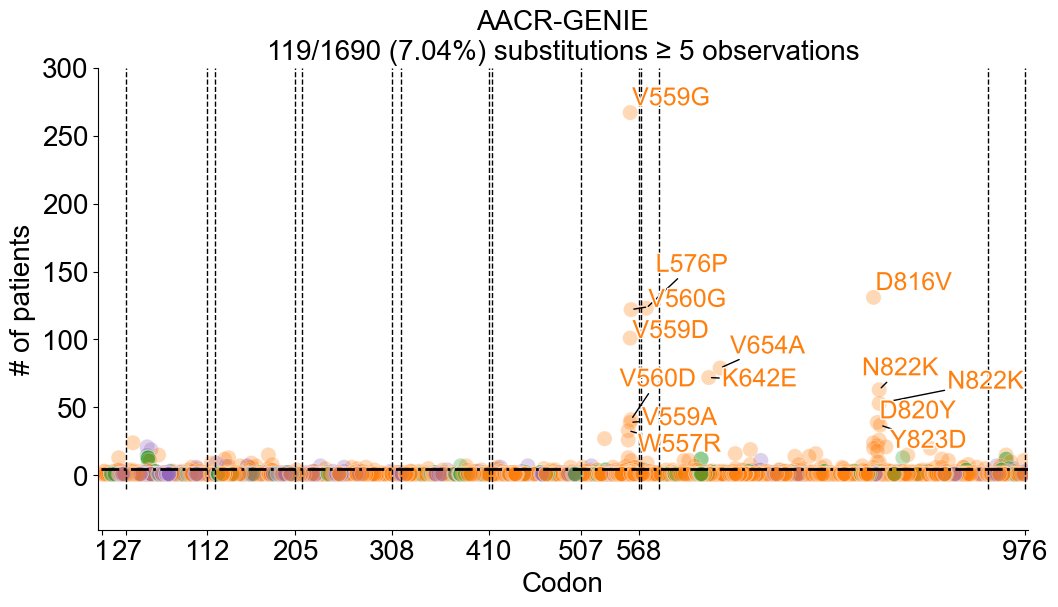

In [261]:
fs = 0
df_merged = df_merged_all[df_merged_all['flank_size'] >= fs].reset_index(drop=True)
gene = 'KIT'
l1 = len(df_merged_all['HGVSp_h'].drop_duplicates())
l2 = len(df_merged_all[df_merged_all['count']>=5]['HGVSp_h'].drop_duplicates())
percent = 100*l2/l1
bbb1 = df_merged[(df_merged['count'] >= 30) ]

bb2 = bbb1

t = list(bb2['HGVSp_h'])
x = list(bb2['loc_h'])
y = list(bb2['count'])
c= list(bb2['color_h2m'])

fig, ax = plt.subplots(figsize=(12, 6))
# 绘制散点图
g = ax.scatter(data=df_merged, x='loc_h', y='count',  c = 'color_h2m', alpha=.3, s=120, edgecolor='white', linewidths=.5)

# 绘制参考线
ax.plot([0, 979], [5, 5], linewidth=2, linestyle='-.', color='black')
# ax.set_ylim(-6, 6)
ax.set_xlim(-3, 979)
ax.set_ylim(-40, 300)
ax.set_ylabel(f"# of patients", fontsize=20)
ax.set_xlabel("Codon", fontsize=20)
ax.set_title(f"AACR-GENIE\n{l2}/{l1} ({percent:.2f}%) substitutions ≥ 5 observations", fontsize=20)
boundaries = [27,112,121,205,212,308,317,410,413,507,568,570,589,937,976]
boundaries_ = [1,27,112,205,308,410,507,568,976]
for bound in boundaries:
    ax.plot([bound, bound], [-10, 300], linewidth=1, linestyle='dashed', color='black')

texts = [ax.text(x[i], y[i], t[i], fontsize=18, color=c[i], path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]

adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=20)

ax.xaxis.set_ticks(boundaries_)
ax.xaxis.set_ticklabels(boundaries_, size=20, fontweight=100)
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_h_freq_{fs}_h2m_colored.pdf', bbox_inches='tight')
plt.show()

## Figure 3d  
Kaplan-Meier Curve visualizing the percentage of human KIT missense mutations that can be modeled by H2M, stratified by function domain.

In [474]:
df_merged_all = df_kit_all
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]

In [475]:
t = ['IG','Trans-/Juxta-membrane','Kinase']
def get_class_region(x):
    t = ['IG','Trans-/Juxta-membrane','Kinase']
    if x <= 507:
        return t[0]
    elif x<= 589:
        return t[1]
    else:
        return t[2]
df_merged_all['region'] = [get_class_region(x) for x in df_merged_all['loc_h']]
color_dict_region = dict(zip(t, ['tab:green','tab:orange','tab:purple']))
df_merged_all['color_region'] = [color_dict_region[x] for x in df_merged_all['region']]

In [476]:
df_merged_all = df_merged_all.drop_duplicates(subset='ID_human').reset_index(drop=True)

In [305]:
df_merged_all['status'] = True

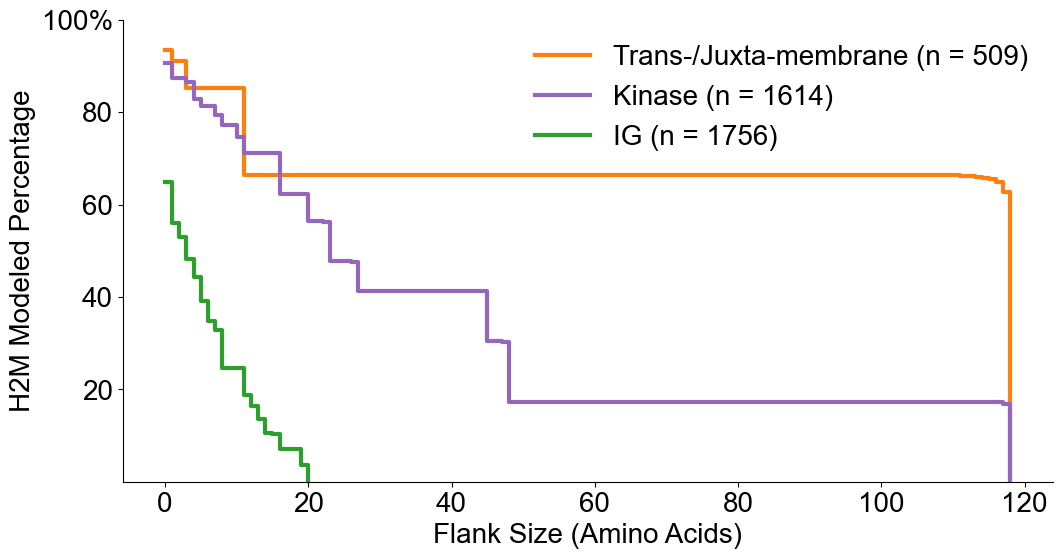

In [306]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=1, nrows=1)
for value in df_merged_all['region'].unique():
    mask = df_merged_all['region'] == value
    color = color_dict_region[value]
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df_merged_all["status"][mask], df_merged_all["flank_size"][mask], conf_type="log-log",
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})", 
             color = color, linewidth=3)
    # plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.yaxis.set_ticks([0.20,0.40,0.60,0.80,1])
ax.yaxis.set_ticklabels(['20','40','60','80','100%'], size=20, fontweight=100)
ax.set_ylabel(f"H2M Modeled Percentage", fontsize=20)
ax.set_xlabel("Flank Size (amino acids)", fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.ylim(0, 1)
plt.xlabel("Flank Size (Amino Acids)")
plt.legend(loc="best",fontsize=20, frameon=False)
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/line.pdf', bbox_inches='tight')
plt.show() # Display the graph

## Figure 3e  
Distribution of AlphaMissense scores for KIT missense mutations under different thresholds of flank size.

In [ ]:
file_path = '/Users/kexindong/Documents/GitHub/Database/Pathogenecity/AlphaMIssense/AlphaMissense_aa_substitutions.tsv'
df_am = pd.read_csv(file_path, sep = '\t',comment='#')
df_kit_am = df_am[df_am['uniprot_id']=='P10721'].reset_index(drop=True)
df_kit_am = df_kit_am.drop('uniprot_id',axis=1)
df_kit_am.columns=['HGVSp_h','am_pathogenicity','am_class']

In [295]:
df_merged_all = df_kit_all
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]

In [296]:
df_h2m = df_merged_all.drop_duplicates(subset='ID_human').reset_index(drop=True)
df_h2m = pd.merge(df_h2m, df_kit_am, how='left').dropna(subset='am_class').reset_index(drop=True)

In [298]:
color_dict_am = dict({
    'pathogenic':'darkred',
    'benign':'darkblue',
    'ambiguous':'grey'
})
df_h2m['color'] = [color_dict_am[x] for x in df_h2m['am_class']]

In [299]:
list_density = []
for fs in [20,10,4,0]:
    df_merged = df_h2m[df_h2m['flank_size'] >= fs].reset_index(drop=True)
    df_merged = df_merged[df_merged['status']==True]
    df_merged = df_merged[['ID_human','HGVSp_h','am_pathogenicity','am_class','loc_h']]
    df_merged['fs'] = f'FS = {fs}'
    list_density.append(df_merged)
df_density = pd.concat(list_density)

In [300]:
df_density = df_density.reset_index(drop=True)

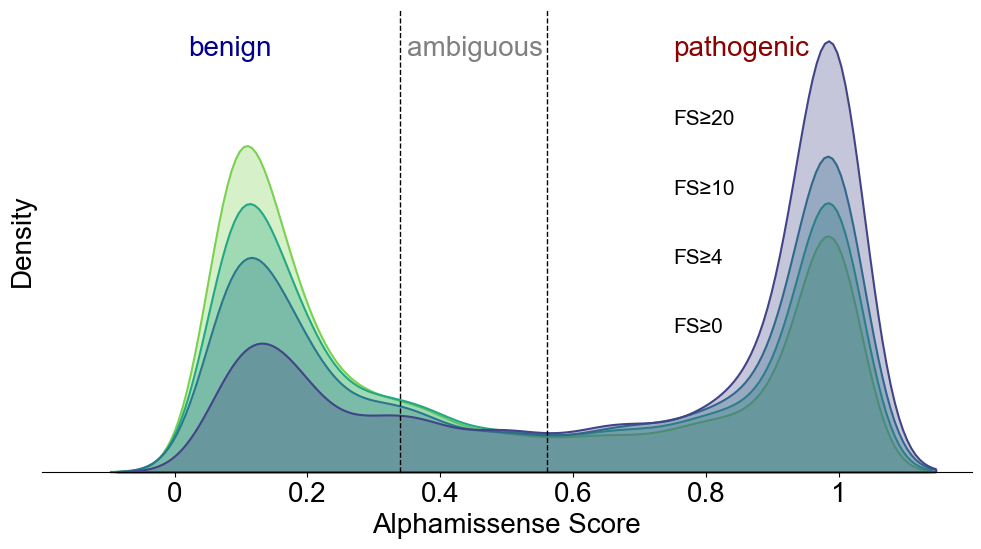

In [301]:
fig, ax = plt.subplots(figsize=(12, 6))
gene = 'KIT'
p = sns.kdeplot(data=df_density, x="am_pathogenicity", hue="fs", fill=True, common_norm=False, alpha=0.3, palette="viridis",  
                ax=ax, bw_adjust=.6,
                clip_on=False,
                linewidth=1.5)
p.legend(loc='upper left', frameon=False)
# control x limit
plt.xlim(-.2, 1.2)
plt.ylim(0, 4)
boundaries = [.34,.56]
for bound in boundaries:
    ax.plot([bound, bound], [0, 6], linewidth=1, linestyle='dashed', color='black')
# add axis names        
ax.set_xlabel("Alphamissense Score",fontsize=20)
ax.set_ylabel("Density",fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks([0,.2,.4,.6,.8,1])
ax.xaxis.set_ticklabels([0,0.2,0.4,0.6,0.8,1], size=20, fontweight=100)
annot = pd.DataFrame({
'x': [0.75]*4,
'y': [3,2.4,1.8,1.2],
'text': list([f'FS≥{fs}' for fs in [20,10,4,0]])
})
ax.yaxis.set_ticks([])
# add annotations one by one with a loop
for point in range(0,len(annot)):
    p.text(annot.x[point], annot.y[point], annot.text[point], horizontalalignment='left', size=15)

annot = pd.DataFrame({
'x': [.75,.02,.35],
'y': [3.6]*3,
'text': list(color_dict_am.keys()),
'color': list(color_dict_am.values())
})
for point in range(0,len(annot)):
    p.text(annot.x[point], annot.y[point], annot.text[point], color = annot.color[point],horizontalalignment='left', size=20)

plt.savefig('/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/database/fs_stratified.pdf',bbox_inches='tight')
plt.show()

## Figure 3f     
AlphaMissense scores for KIT mutations under different thresholds of flank size.

In [335]:
df_merged_all.to_csv('/Users/kexindong/Documents/GitHub/Output/df_merged_all',index=False)

In [479]:
df_merged_all = df_kit_all
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]
df_merged_all = df_merged_all.drop_duplicates(subset='ID_human').reset_index(drop=True)

In [480]:
df_merged_all = pd.merge(df_merged_all, df_kit_am, how='left').dropna(subset='am_class').reset_index(drop=True)
df_merged_all['color'] = [color_dict_am[x] for x in df_merged_all['am_class']]

In [482]:
t = ['IG','Trans-/Juxta-membrane','Kinase']
def get_class_region(x):
    t = ['IG','Trans-/Juxta-membrane','Kinase']
    if x <= 507:
        return t[0]
    elif x<= 589:
        return t[1]
    else:
        return t[2]
df_merged_all['region'] = [get_class_region(x) for x in df_merged_all['loc_h']]
color_dict_region = dict(zip(t, ['tab:green','tab:orange','tab:purple']))
df_merged_all['color_region'] = [color_dict_region[x] for x in df_merged_all['region']]

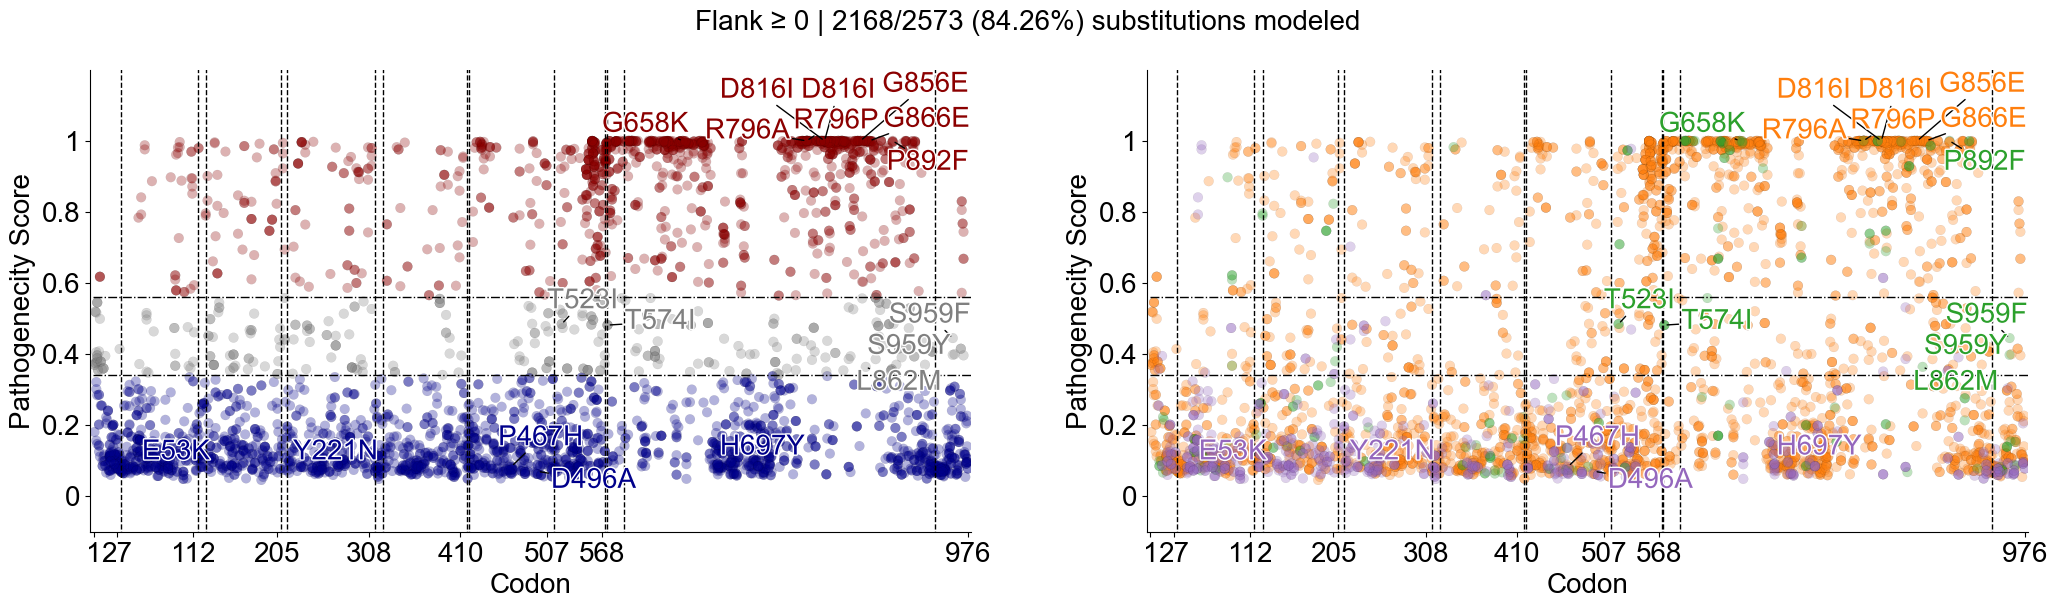

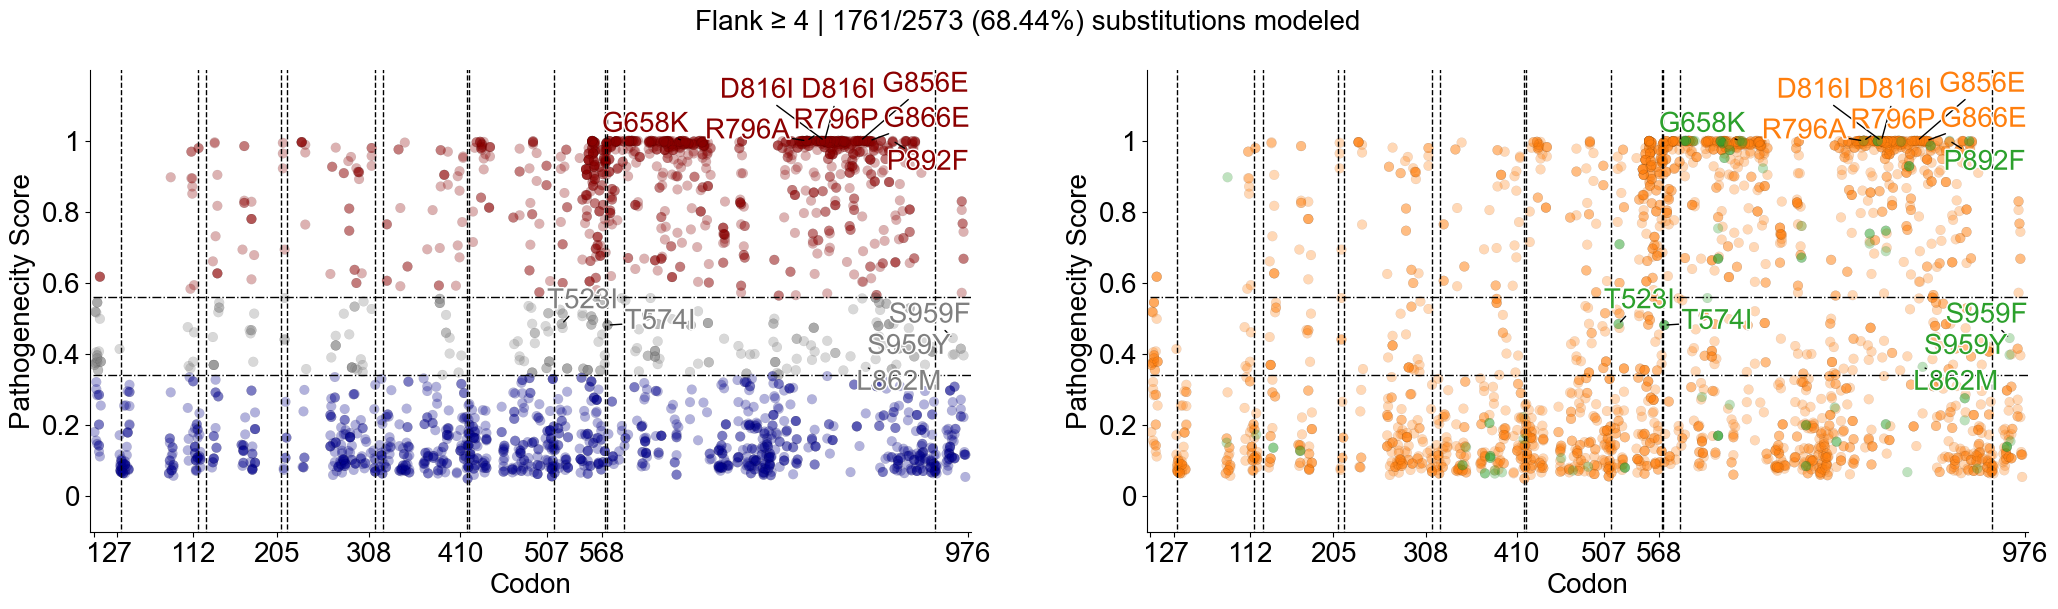

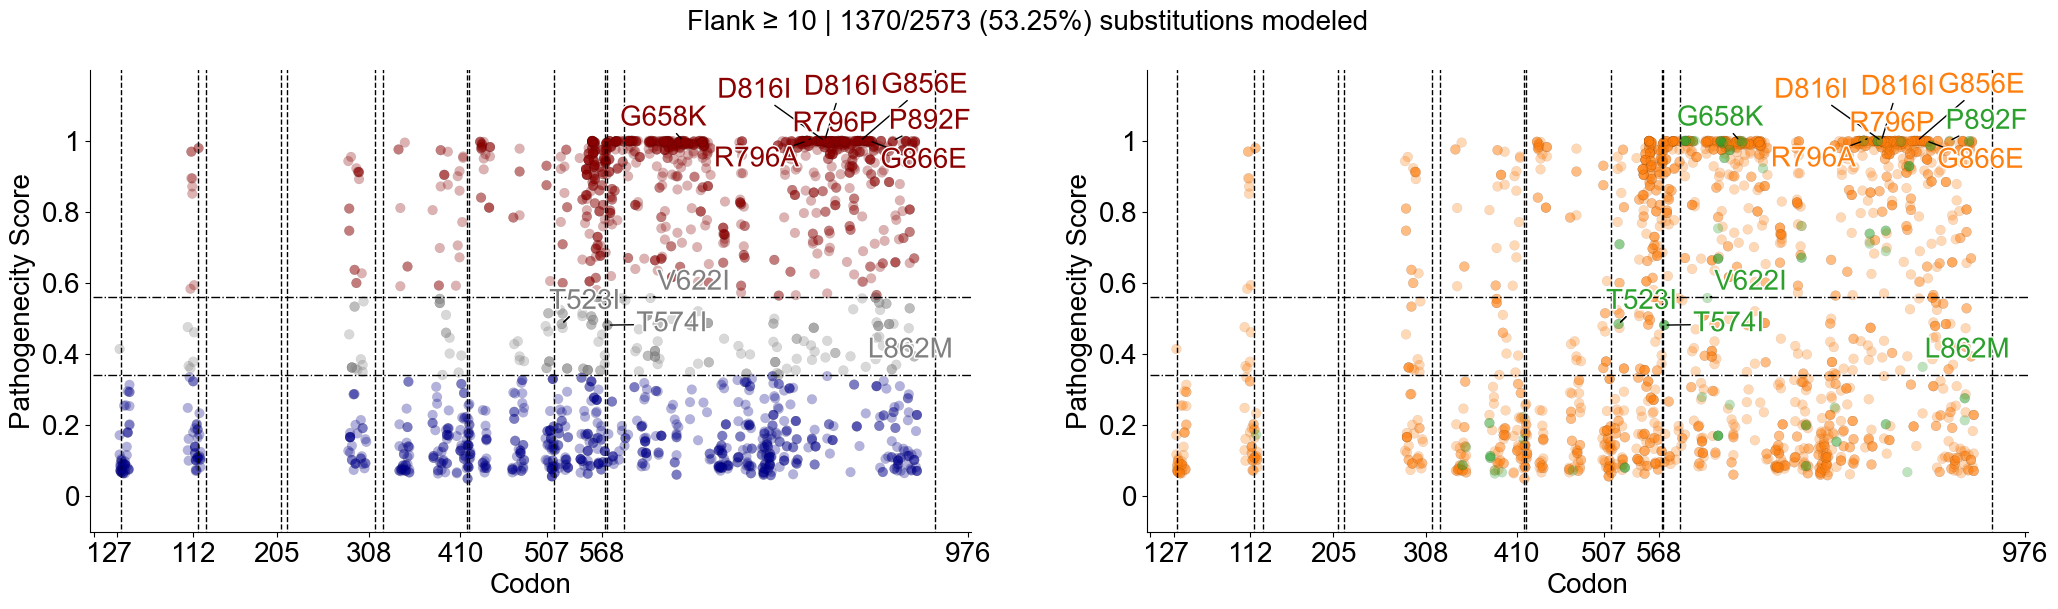

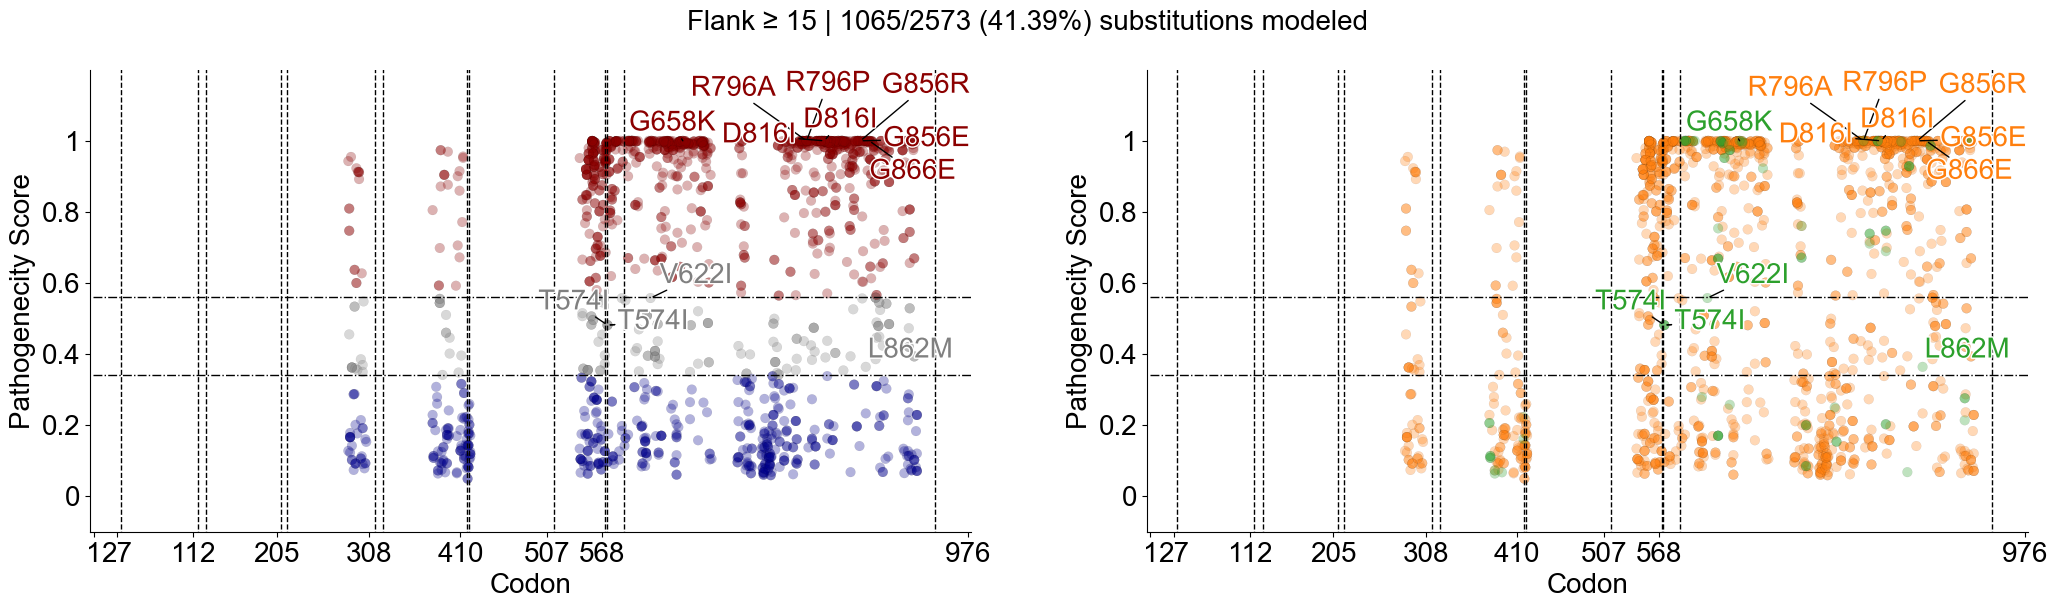

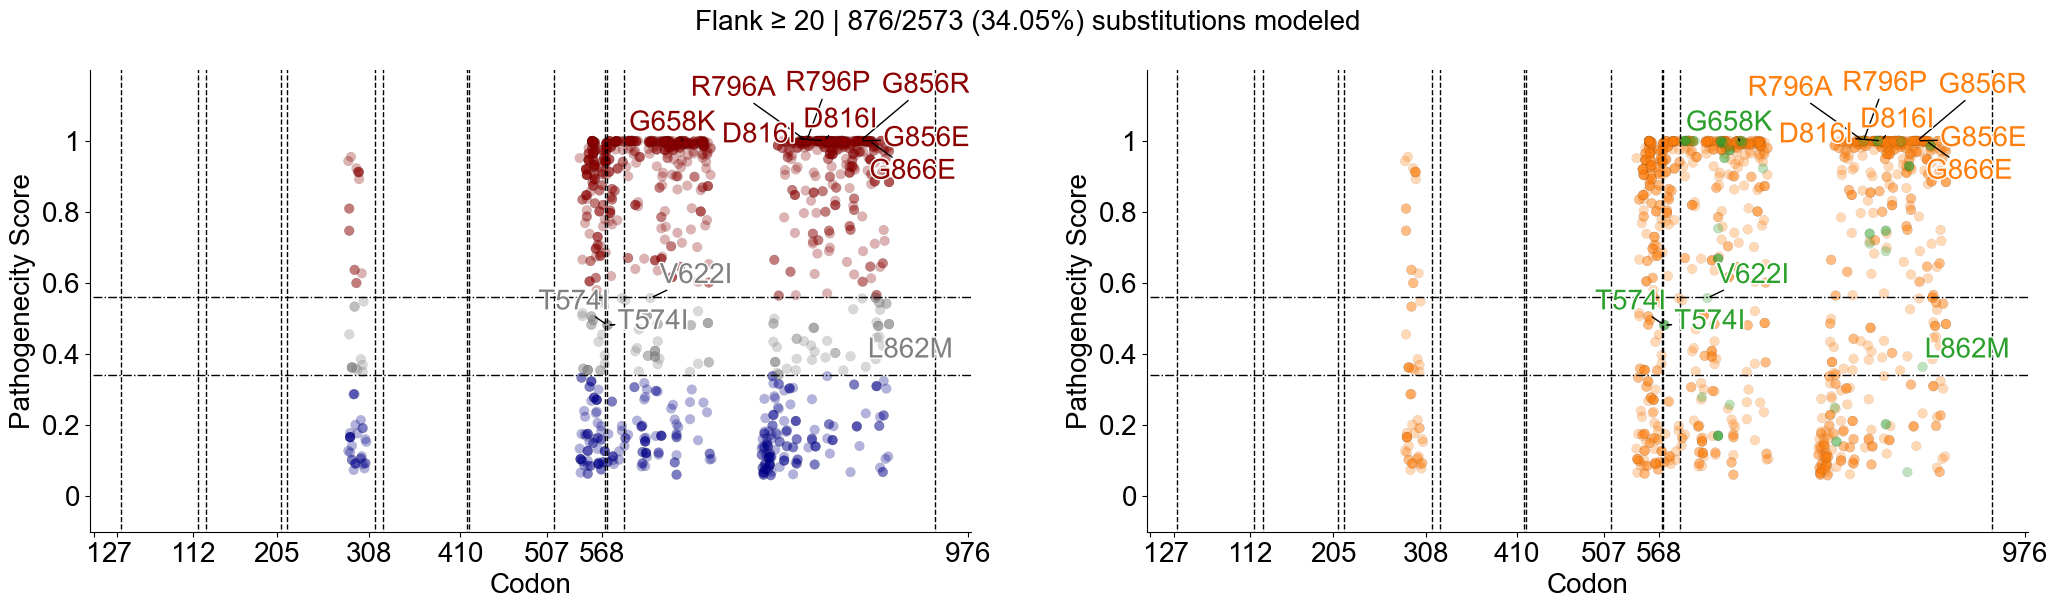

In [483]:
for fs in [0,4,10,15,20]:
    df_merged = df_merged_all[df_merged_all['flank_size'] >= fs].reset_index(drop=True)
    gene = 'KIT'
    l1 = len(df_merged_all['HGVSp_h'].drop_duplicates())
    l2 = len(df_merged[df_merged['status']==True]['HGVSp_h'].drop_duplicates())
    percent = 100*l2/l1
    bbb1 = df_merged[(df_merged['am_pathogenicity'] >= .99984) & (df_merged['status'] == True)].iloc[:8,:]
    bbb2 = df_merged[(df_merged['am_pathogenicity'] <= .2) & (df_merged['status'] == False)].iloc[:5,:]
    bbb3 = df_merged[(df_merged['class'] == 1) & (df_merged['am_pathogenicity'] <= .6) & (df_merged['am_pathogenicity'] >= .3)].iloc[:5,:]
    # top_2 = df_merged['HGVSp_h'].value_counts().index.to_list()[:2]
    # bbb3 = df_merged[df_merged['HGVSp_h'].isin(top_2)]
    bb2 = pd.concat((bbb1, bbb2,bbb3))

    t = list(bb2['HGVSp_h'])
    x = list(bb2['loc_h'])
    y = list(bb2['am_pathogenicity'])
    c = list(bb2['color'])

    fig, (ax,ax2) = plt.subplots(figsize=(25, 6),nrows=1, ncols=2)
    # 绘制散点图
    g = ax.scatter(data=df_merged, x='loc_h', y='am_pathogenicity',  c = 'color', alpha=.3, s=50, edgecolor='black', linewidths=.1)

    # 绘制参考线
    ax.plot([0, 979], [0.56, 0.56], linewidth=1, linestyle='-.', color='black')
    ax.plot([0, 979], [0.34, 0.34], linewidth=1, linestyle='-.', color='black')
    # ax.set_ylim(-6, 6)
    ax.set_xlim(-3, 979)
    ax.set_ylim(-.1, 1.2)
    ax.set_ylabel(f"Pathogenecity Score", fontsize=20)
    ax.set_xlabel("Codon", fontsize=20)
    # ax.set_title(f"Flank ≥ {fs}\n{l2}/{l1} ({percent:.2f}%) variants modeled", fontsize=20)
    boundaries = [31,117,126,210,217,315,324,417,420,514,571,573,592,939]
    for bound in boundaries:
        ax.plot([bound, bound], [-6, 6], linewidth=1, linestyle='dashed', color='black')

    texts = [ax.text(x[i], y[i], t[i], fontsize=20, color=c[i], path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]
    ax.yaxis.set_ticks([0,.2,.4,.6,.8,1])
    ax.yaxis.set_ticklabels([0,0.2,0.4,0.6,0.8,1], size=20, fontweight=100)
    adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    boundaries_ = [1,27,112,205,308,410,507,568,976]
    ax.xaxis.set_ticks(boundaries_)
    ax.xaxis.set_ticklabels(boundaries_, size=20, fontweight=100)
    ax.tick_params(axis='x', which='major', labelsize=20)
    

    c = list(bb2['color_h2m'])

    # 绘制散点图
    gg = ax2.scatter(data=df_merged, x='loc_h', y='am_pathogenicity',  c = 'color_h2m', alpha=.3, s=50, edgecolor='black',  linewidths=.1)

    # 绘制参考线
    ax2.plot([0, 979], [0.56, 0.56], linewidth=1, linestyle='-.', color='black')
    ax2.plot([0, 979], [0.34, 0.34], linewidth=1, linestyle='-.', color='black')
    # ax.set_ylim(-6, 6)
    ax2.set_xlim(-3, 979)
    ax2.set_ylim(-.1, 1.2)
    ax2.set_ylabel(f"Pathogenecity Score", fontsize=20)
    ax2.set_xlabel("Codon", fontsize=20)

    boundaries = [31,117,126,210,217,315,324,417,420,514,571,573,592,939]
    for bound in boundaries:
        ax2.plot([bound, bound], [-6, 6], linewidth=1, linestyle='dashed', color='black')

    texts = [ax2.text(x[i], y[i], t[i], fontsize=20, color=c[i], path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]
    ax2.yaxis.set_ticks([0,.2,.4,.6,.8,1])
    ax2.yaxis.set_ticklabels([0,0.2,0.4,0.6,0.8,1], size=20, fontweight=100)
    adjust_text(texts,only_move={'texts':'xy'}, ax=ax2, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
    boundaries_ = [1,27,112,205,308,410,507,568,976]
    ax2.xaxis.set_ticks(boundaries_)
    ax2.xaxis.set_ticklabels(boundaries_, size=20, fontweight=100)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='x', which='major', labelsize=20)
    # plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_h_fs_{fs}_h2m_colored.pdf', bbox_inches='tight')
    plt.suptitle(f"Flank ≥ {fs} | {l2}/{l1} ({percent:.2f}%) substitutions modeled", fontsize=20)
    plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_h_fs_{fs}.pdf', bbox_inches='tight')
    plt.show()

## **For 3g-h:**  

In [336]:
# conda env create -n stat_env -f ./stat_env.yml
#----then in the future to actiavte-------
#module load miniconda3/v4
#source /home/software/conda/miniconda3/bin/condainit
################################
# NEED TO USE: seaborn==0.11.0
################################

## Figure 3g 

Box plot of the AlphaMissense scores of KIT variants that can be modeled in mice by H2M, stratified by different functional domains.

In [ ]:
df_merged_all_keep = df_merged_all
df_merged_all_plot = df_merged_all[df_merged_all['status']==True].reset_index(drop=True)

In [ ]:
t = ['IG','Trans-/Juxta-membrane','Kinase']
def get_class_region(x):
    t = ['IG','Trans-/Juxta-membrane','Kinase']
    if x <= 507:
        return t[0]
    elif x<= 589:
        return t[1]
    else:
        return t[2]
df_merged_all['region'] = [get_class_region(x) for x in df_merged_all['loc_h']]
color_dict_region = dict(zip(t, ['tab:green','tab:orange','tab:purple']))
color_dict_region_2 = dict(zip(t, ['grey']*3))
df_merged_all['color_region'] = [color_dict_region[x] for x in df_merged_all['region']]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Kinase v.s. IG: t-test independent samples with Bonferroni correction, P_val=5.354e-105 stat=2.278e+01
Trans-/Juxta-membrane v.s. Kinase: t-test independent samples with Bonferroni correction, P_val=1.967e-01 stat=-1.842e+00
Trans-/Juxta-membrane v.s. IG: t-test independent samples with Bonferroni correction, P_val=1.267e-50 stat=1.553e+01


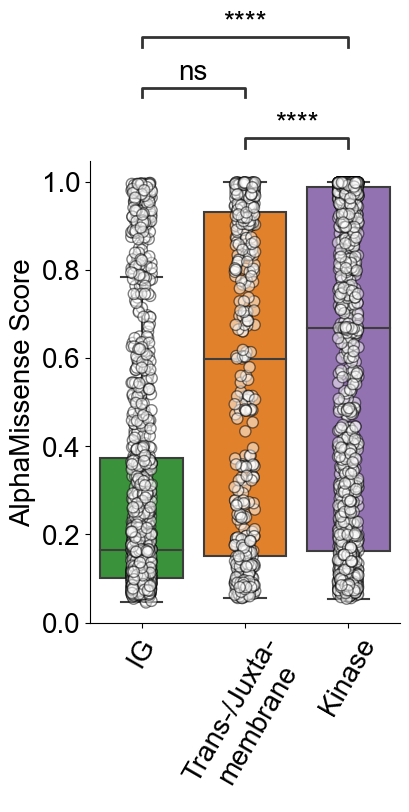

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))
g = sns.boxplot(data=df_merged_all, x='region', y='am_pathogenicity', ax=ax, palette=color_dict_region, order=t,showfliers=False)
g1 = sns.stripplot(data=df_merged_all, x='region', y='am_pathogenicity', ax=ax, color = 'white', alpha = .5,order=t, edgecolor='black', size = 8, linewidth=1)
#ax.set_xticklabels(['Mis-\nsense', 'Non-\nsense', 'INS', 'DEL', 'Silent'])
#ax.set_xlabel('')
#ax.set_ylabel('LFC D34-Nutlin', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(f"AlphaMissense Score", fontsize=20)
ax.set_xlabel("", fontsize=20)
statannot.add_stat_annotation(
    ax,
    data=df_merged_all,
    x='region',
    y='am_pathogenicity',
    #hue=hue,
    box_pairs=[
        ((t[0]), (t[1])),
        ((t[0]), (t[2])),
        ((t[1]), (t[2]))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
    fontsize = 20,
    linewidth=2
)
plt.xticks(ticks=[0,1,2], labels=['IG', 'Trans-/Juxta-\nmembrane', 'Kinase'], rotation=60)
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/bar_pathogenecity.pdf', bbox_inches='tight')
plt.show()

## Figure 3h 

Box plot of the flank sizes of KIT variants that can be modeled in mice by H2M, stratified by different functional domains. Statistic p-values are labeled the same as the previous panel.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Kinase v.s. IG: t-test independent samples with Bonferroni correction, P_val=2.715e-189 stat=3.181e+01
Trans-/Juxta-membrane v.s. Kinase: t-test independent samples with Bonferroni correction, P_val=2.059e-72 stat=1.884e+01
Trans-/Juxta-membrane v.s. IG: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=5.364e+01


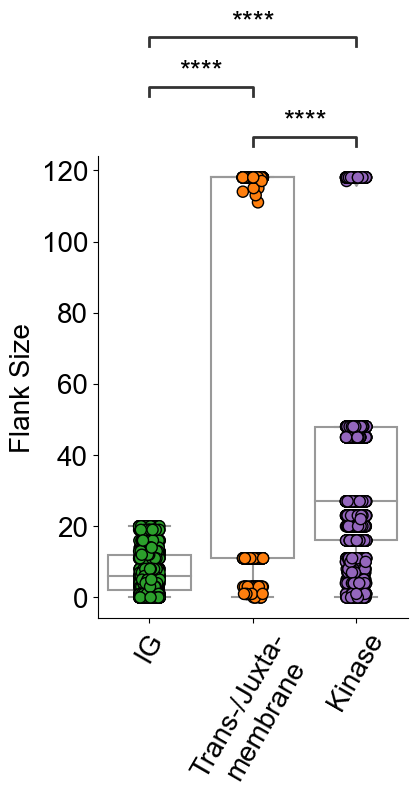

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))
g = sns.boxplot(data=df_merged_all, x='region', y='flank_size', ax=ax, color = 'white', order=t)
g1 = sns.stripplot(data=df_merged_all, x='region', y='flank_size', ax=ax, palette=color_dict_region, 
                   order=t, edgecolor='black', size = 8, linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(f"Flank Size", fontsize=20)
ax.set_xlabel("", fontsize=20)
statannot.add_stat_annotation(
    ax,
    data=df_merged_all,
    x='region',
    y='flank_size',
    #hue=hue,
    box_pairs=[
        ((t[0]), (t[1])),
        ((t[0]), (t[2])),
        ((t[1]), (t[2]))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
    fontsize = 20,
    linewidth=2
)
plt.xticks(ticks=[0,1,2], labels=['IG', 'Trans-/Juxta-\nmembrane', 'Kinase'], rotation=60)
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/bar_fs.pdf', bbox_inches='tight')
plt.show()

## Figure 3i  

In [353]:
# df_freq[df_freq['count']>=5].reset_index(drop=True).to_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/database-output-final/df_kit_freq_over_5.csv',index=False)

In [356]:
sift_m = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_input/sift_m_2.txt',sep='\t', comment = '#')
sift_h = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_input/sift_h_2.txt',sep='\t', comment = '#')

In [357]:
sift_m_result = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_output/sift_m_2_SIFT_kit.csv')
sift_m.columns = ['CHROM',	'start_m',	'ID_human',	'ref_seq_m',	'alt_seq_m',	'QUAL',	'FILTER',	'INFO',	'FORMAT',	'MP96-Ripoll-MRC-Harwell']
sift_h.columns = ['CHROM',	'start_h',	'ID_human',	'ref_seq_h',	'alt_seq_h',	'QUAL',	'FILTER',	'INFO',	'FORMAT',	'MP96-Ripoll-MRC-Harwell']
# df_binded = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/database-output-final/df_result_cleaned_v3.csv')
sub_result_m = sift_m_result[['POS','REF_ALLELE','ALT_ALLELE','SIFT_SCORE','SIFT_PREDICTION']]
sub_result_m.columns = ['start_m','ref_seq_m','alt_seq_m','SIFT_SCORE','SIFT_PREDICTION']
sub_result_m = pd.merge(sift_m,sub_result_m, how='outer',on = ['start_m','ref_seq_m','alt_seq_m'])

In [359]:
sift_h_result = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/sift_h_SIFT_kit.csv')
sub_result_h = sift_h_result[['POS','REF_ALLELE','ALT_ALLELE','SIFT_SCORE','SIFT_PREDICTION']]
sub_result_h.columns = ['start_h','ref_seq_h','alt_seq_h','SIFT_SCORE','SIFT_PREDICTION']
sift_h_result = pd.merge(sift_h,sub_result_h, how='outer',on = ['start_h','ref_seq_h','alt_seq_h'])

sift_h_result_plot = sift_h_result[['ID_human','SIFT_SCORE','SIFT_PREDICTION']]
sift_h_result_plot.columns = ['ID_human','SIFT_SCORE_h','SIFT_PREDICTION_h']
sift_m_result_plot = sub_result_m[['ID_human','SIFT_SCORE','SIFT_PREDICTION']]
sift_m_result_plot.columns = ['ID_human','SIFT_SCORE_m','SIFT_PREDICTION_m']

In [360]:
df_SIFT_kit = pd.merge(sift_h_result_plot, sift_m_result_plot, on = 'ID_human').dropna()

In [362]:
df_SIFT_kit

ID_human  SIFT_SCORE_h SIFT_PREDICTION_h  SIFT_SCORE_m  \
0    AACR-H0004152         0.416         TOLERATED         0.681   
6    AACR-H0010103         0.797         TOLERATED         0.105   
7    AACR-H0012038         0.267         TOLERATED         0.296   
8    AACR-H0007687         0.248         TOLERATED         0.262   
9    AACR-H0030639         0.135         TOLERATED         0.128   
..             ...           ...               ...           ...   
100  AACR-H0048772         0.166         TOLERATED         0.308   
101  AACR-H0026674         0.097         TOLERATED         0.107   
102  AACR-H0007529         0.009       DELETERIOUS         0.046   
107  AACR-H0014362         0.281         TOLERATED         0.122   
108  AACR-H0012190         0.198         TOLERATED         0.012   

    SIFT_PREDICTION_m  
0           TOLERATED  
6           TOLERATED  
7           TOLERATED  
8           TOLERATED  
9           TOLERATED  
..                ...  
100         TOLERATED  
101         TOLERATED  
102       DELETERIOUS  
107         TOLERATED  
108       DELETERIOUS  

[96 rows x 5 columns]

In [363]:
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','HGVSp_h','HGVSp_m','class']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','flank_size']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','classification_h']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = df_SIFT_kit[df_SIFT_kit['classification_h']!='Silent']

In [366]:
df_SIFT_kit['SIFT_PREDICTION_h'].value_counts()

DELETERIOUS    55
TOLERATED      41
Name: SIFT_PREDICTION_h, dtype: int64

In [369]:
color_dict_sift = ({
    'DELETERIOUS':'darkred',
    'TOLERATED':'tab:blue'
})
df_h2m = df_SIFT_kit

In [371]:
# Function to blend two colors
def blend_colors(color1, color2):
    # Convert color names to RGBA
    rgb1 = np.array(mcolors.to_rgb(color1))
    rgb2 = np.array(mcolors.to_rgb(color2))
    # Calculate the average of the RGB components
    blended_rgb = (rgb1 + rgb2) / 2
    # Convert the blended RGB back to hex color code
    return mcolors.to_hex(blended_rgb)

# Create a combined color dictionary
combined_color_dict = {}
for key1 in color_dict_sift:
    for key2 in color_dict_sift:
        # Blend each pair of colors
        combined_color_dict[(key1, key2)] = blend_colors(color_dict_sift[key1], color_dict_sift[key2])

In [372]:
df_h2m['color_class'] = [color_dict_h2m[x] for x in df_h2m['class']]
df_h2m['color_score'] = df_h2m.apply(lambda row: combined_color_dict[(row['SIFT_PREDICTION_h'], row['SIFT_PREDICTION_m'])], axis=1)
df_h2m['loc_h'] = [search_loc(s) for s in  df_h2m['HGVSp_h']]
df_h2m['loc_m'] = [search_loc(s) for s in  df_h2m['HGVSp_m']]
df_h2m['color_h2m_h'] = [color_dict_sift[x] for x in df_h2m['SIFT_PREDICTION_h']]
df_h2m['color_h2m_m'] = [color_dict_sift[x] for x in df_h2m['SIFT_PREDICTION_m']]

In [384]:
corr, p_value = scipy.stats.spearmanr(df_h2m['SIFT_SCORE_h'], df_h2m['SIFT_SCORE_m'])

print("Spearman Correlation Coefficient: {:.4f}".format(corr))
print("P-value: {:.4f}".format(p_value))

Spearman Correlation Coefficient: 0.9678
P-value: 0.0000


In [385]:
corr_p, p_value = scipy.stats.pearsonr(df_h2m['SIFT_SCORE_h'], df_h2m['SIFT_SCORE_m'])

print("Pearson Correlation Coefficient: {:.4f}".format(corr))
print("P-value: {:.4f}".format(p_value))

Pearson Correlation Coefficient: 0.9678
P-value: 0.0000


In [387]:
n_of_subs = len(df_h2m['HGVSp_h'].unique())

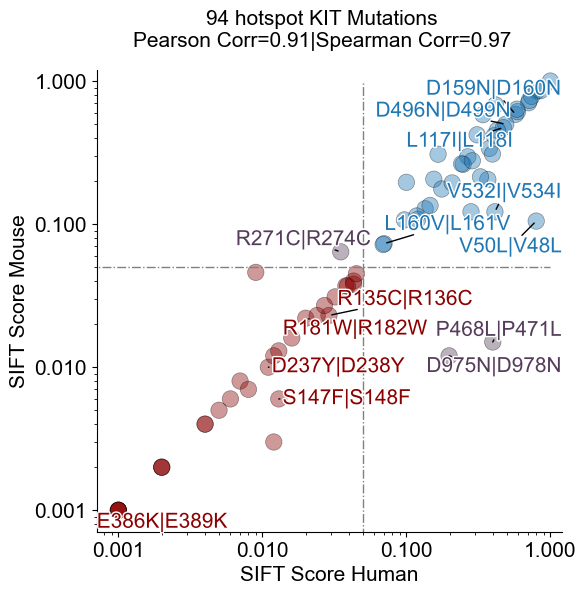

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
gene_1 = 'KIT'
gene_2 = 'Kit'

bbb1 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m']<=.05)].iloc[:5,:]
bbb2 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= .4) & (df_h2m['SIFT_SCORE_m'] <= .6)].iloc[:5,:]
bbb3 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= .097) & (df_h2m['SIFT_SCORE_m'] <= .097) ].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m'] >= .05) ].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= 0.05) & (df_h2m['SIFT_SCORE_m'] <= 0.05) ].iloc[:3,:]
bbb6 = df_h2m[df_h2m['class']==1]


bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4,bbb5, bbb6)).drop_duplicates(subset= 'HGVSp_h')

t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h'], bb2['HGVSp_m'])]
x = list(bb2['SIFT_SCORE_h'])
y = list(bb2['SIFT_SCORE_m'])
c = list(bb2['color_score'])


ax.plot([0, 1], [0.05, 0.05], linewidth=1, linestyle='-.', color='grey')
ax.plot( [0.05, 0.05], [0, 1],linewidth=1, linestyle='-.', color='grey')

plt.xscale('log')
plt.yscale('log')
# ax.plot( [0,1], [0, 1],linewidth=1, linestyle='-', color='grey')
ax.scatter(data=df_h2m, x='SIFT_SCORE_h', y='SIFT_SCORE_m', c = 'color_score', alpha=.4, s=140, edgecolor='black', linewidths=.5)

ax.set_xlim(-.03, 1.2)
ax.set_ylim(-.03, 1.2)
ax.set_xlabel(f"SIFT Score Human", fontsize=15)
ax.set_ylabel(f"SIFT Score Mouse", fontsize=15)
plt.suptitle(f"{n_of_subs} hotspot KIT Mutations\nPearson Corr={corr_p:.2f}|Spearman Corr={corr:.2f}", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], fontsize=15, color=c[i], path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
def format_func(value, tick_number):
    return f"{value:.3f}"
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_sift_sift_colored.pdf', bbox_inches='tight')
plt.show()

## Extended figure 4a

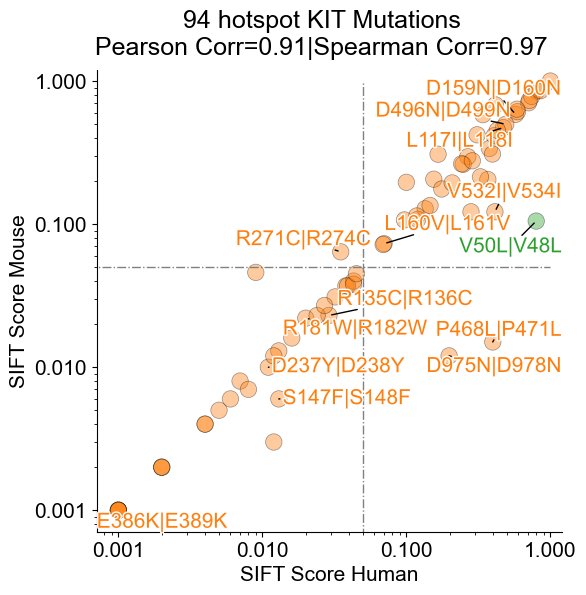

In [444]:
fig, ax = plt.subplots(figsize=(6, 6))
gene_1 = 'KIT'
gene_2 = 'Kit'

bbb1 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m']<=.05)].iloc[:5,:]
bbb2 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= .4) & (df_h2m['SIFT_SCORE_m'] <= .6)].iloc[:5,:]
bbb3 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= .097) & (df_h2m['SIFT_SCORE_m'] <= .097) ].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m'] >= .05) ].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= 0.05) & (df_h2m['SIFT_SCORE_m'] <= 0.05) ].iloc[:3,:]
bbb6 = df_h2m[df_h2m['class']==1]
bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4,bbb5, bbb6)).drop_duplicates(subset= 'HGVSp_h')


t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h'], bb2['HGVSp_m'])]
x = list(bb2['SIFT_SCORE_h'])
y = list(bb2['SIFT_SCORE_m'])
c = list(bb2['color_class'])


ax.plot([0, 1], [0.05, 0.05], linewidth=1, linestyle='-.', color='grey')
ax.plot( [0.05, 0.05], [0, 1],linewidth=1, linestyle='-.', color='grey')

plt.xscale('log')
plt.yscale('log')
# ax.plot( [0,1], [0, 1],linewidth=1, linestyle='-', color='grey')
ax.scatter(data=df_h2m, x='SIFT_SCORE_h', y='SIFT_SCORE_m', c = 'color_class', alpha=.4, s=140, edgecolor='black', linewidths=.5)

ax.set_xlim(-.03, 1.2)
ax.set_ylim(-.03, 1.2)
ax.set_xlabel(f"SIFT Score Human", fontsize=15)
ax.set_ylabel(f"SIFT Score Mouse", fontsize=15)
plt.suptitle(f"{n_of_subs} hotspot KIT Mutations\nPearson Corr={corr_p:.2f}|Spearman Corr={corr:.2f}", fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], fontsize=15, color=c[i], path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
def format_func(value, tick_number):
    return f"{value:.3f}"
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_sift_h2m_colored.pdf', bbox_inches='tight')
plt.show()

## Extended Figure 4b

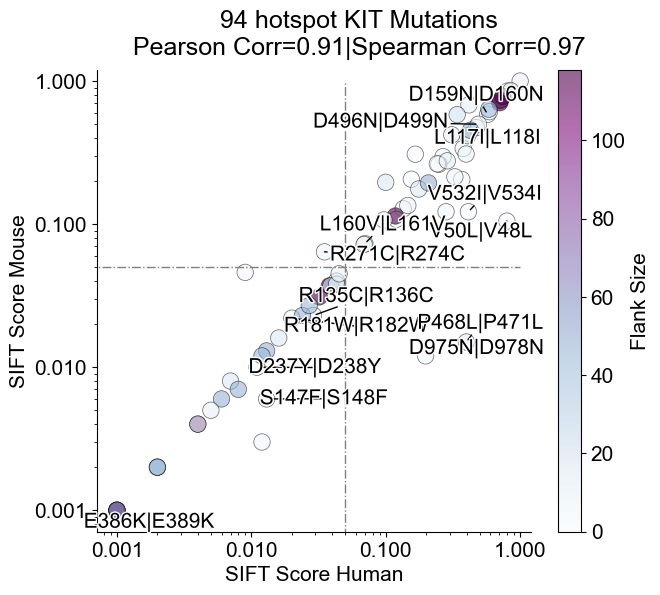

In [449]:
fig, ax = plt.subplots(figsize=(7, 6))
gene_1 = 'KIT'
gene_2 = 'Kit'

bbb1 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m']<=.05)].iloc[:5,:]
bbb2 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= .4) & (df_h2m['SIFT_SCORE_m'] <= .6)].iloc[:5,:]
bbb3 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= .097) & (df_h2m['SIFT_SCORE_m'] <= .097) ].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m'] >= .05) ].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= 0.05) & (df_h2m['SIFT_SCORE_m'] <= 0.05) ].iloc[:3,:]
bbb6 = df_h2m[df_h2m['class']==1]

bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4,bbb5, bbb6)).drop_duplicates(subset= 'HGVSp_h')
t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h'], bb2['HGVSp_m'])]
x = list(bb2['SIFT_SCORE_h'])
y = list(bb2['SIFT_SCORE_m'])
c = list(bb2['flank_size'])


ax.plot([0, 1], [0.05, 0.05], linewidth=1, linestyle='-.', color='grey')
ax.plot( [0.05, 0.05], [0, 1],linewidth=1, linestyle='-.', color='grey')

plt.xscale('log')
plt.yscale('log')
# ax.plot( [0,1], [0, 1],linewidth=1, linestyle='-', color='grey')
g = ax.scatter(data=df_h2m, x='SIFT_SCORE_h', y='SIFT_SCORE_m', cmap = plt.cm.BuPu,c = 'flank_size', alpha=.6, s=140, edgecolor='black', linewidths=.5)
ax.set_xlim(-.03, 1.2)
ax.set_ylim(-.03, 1.2)
ax.set_xlabel(f"SIFT Score Human", fontsize=15)
ax.set_ylabel(f"SIFT Score Mouse", fontsize=15)
plt.suptitle(f"{n_of_subs} hotspot KIT Mutations\nPearson Corr={corr_p:.2f}|Spearman Corr={corr:.2f}", fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], fontsize=15, color='black',  path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
def format_func(value, tick_number):
    return f"{value:.3f}"
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
cbar = plt.colorbar(g)
cbar.set_label(label='Flank Size', fontsize = 15)
cbar.ax.tick_params(labelsize = 15)
plt.savefig(f'/Users/kexindong/Documents/GitHub/Output/h2m_database/figures/flank_size/kit_sift_flank_colored.pdf', bbox_inches='tight')
plt.show()

# Output supplemetal data 

In [457]:
df_output_sift = df_h2m[['HGVSp_h','HGVSp_m','flank_size','class','loc_h','loc_m','SIFT_SCORE_h','SIFT_PREDICTION_h','SIFT_SCORE_m','SIFT_PREDICTION_m']].sort_values(by='loc_h')
df_output_sift['gene'] = 'KIT'
df_output_sift.to_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/kit_sift.csv',index=False)

In [477]:
df_merged_all['region']

0       Trans-/Juxta-membrane
1                      Kinase
2                      Kinase
3                      Kinase
4       Trans-/Juxta-membrane
                ...          
3874    Trans-/Juxta-membrane
3875                   Kinase
3876    Trans-/Juxta-membrane
3877    Trans-/Juxta-membrane
3878                   Kinase
Name: region, Length: 3879, dtype: object

In [484]:
df_output_sift_af = df_merged_all[['gene_name_h','HGVSp_h','HGVSp_m','flank_size','class','loc_h','am_class','am_pathogenicity','region']].drop_duplicates().sort_values(by='loc_h').reset_index(drop=True).fillna('N/A')
df_output_sift_af.to_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/kit_am.csv',index=False)